# Parsing textual data - Survey for French presidential elections 2nd round

**Introduction : ** 
This is the second notebook exploring my own dataset from a survey I carried out. Instead of looking at just numbers, which I could just as easily find from official polls, I wanted some open-ended responses. This contains richer information that can be played with. 

**Summary: **

I focus on using IBM Watson to translate from French into English and then parse the emotional content of open-ended survey responses. We find that **responses that mention Marine Le Pen seem to raise the meter for fear compared to those that mention Emmanuel Macron.** 

The Part I notebook explores the question of where first round votes for neither Macron nor Le Pen were likely to go to. 

#### Steps:
1) Translate all open-ended responses with **IBM LanguageTranslator**. 
- *Why LanguageTranslate?: *I do not read French, and got tired of copying and pasting into Google Translate, even though I learnt a few words this way.

2)  **Prepare the data** 

- For ease of analysis and more reliability, I decided to extract all the open-ended responses into one list variable regardless of question posed, 
- and focus the responses that mentioned Le Pen and those that mentioned Macron. 

3) Analyze the textual data with **IBM ToneAnalyzer**, 
- This gives us a rating on 5 emotions on the scale of {0,1}. 
- *Why ToneAnalyzer?:* It's a simple way of analyzing all 1014 responses with IBM Watson. Voters vote on emotion too

4) Acknowledging the non-normality of these emotion metrics, I apply the **Kolmogorov-Smirnov test** to 
- compare Le Pen and Macron on the distributions of these five emotions, and 
- plot their cumulative distribution functions as a visual check.  



##### Ideas for further analysis: 

- Multiply each response into more data by stripping into seperate sentences and attaching the voting intention as a binary outcome (e.g. 1 Macron, 0 Le Pen). 

- Read sample responses that are off the charts for fear. Try to get a sense for what is driving this 'fear' in the Watson API.

- Split data into Le Pen supporter vs Macron supporter.

- Re-do survey design such that all open-ended answers are compulsory, at the cost of survey respondents dropping out. 

- Extract connotations for other words with word2vec. 

----------------

## Imports

In [12]:
import pandas as pd 
pd.set_option('display.max_columns', 300)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import json 
from watson_developer_cloud import ToneAnalyzerV3
from watson_developer_cloud import LanguageTranslatorV2

# Translator 

In [123]:
import getpass
print("conversation username:")
username = getpass.getpass()

print("conversation password:")
password = getpass.getpass()

#do not run this as I have already saved the output in the data/ folder

conversation username:
········
conversation password:
········


In [94]:
language_translator = LanguageTranslatorV2(
    username=username,
    password=password)


# Survey data with Translator

In [95]:
def translatee(x):
    if x == "":
        return ""
    else:    
        return language_translator.translate(x, source='fr',
                                  target='en')
   

In [97]:
dff=pd.read_csv("../data/survey2_cleaned.csv", encoding="utf-8", low_memory=False,infer_datetime_format=True)

In [98]:
teststring=dff["Q14"][dff["Q14"]!=""]
teststring=teststring[0:100]
teststring.head()
translatee(teststring[4])

'France is not ready to host a woman in power and even less someone from extremism '

In [30]:
dff['Q14-en'] = dff['Q14'].apply(lambda x : translatee(x))
dff['Q16-en'] = dff['Q16'].apply(lambda x : translatee(x))
dff['Q18-en'] = dff['Q18'].apply(lambda x : translatee(x))
dff['Q4-en'] = dff['Q4-text'].apply(lambda x : translatee(x))
dff['Q5-en'] = dff['Q5-text'].apply(lambda x : translatee(x))
dff['Q6-en'] = dff['Q6-text'].apply(lambda x : translatee(x))
dff['Q7-en'] = dff['Q7-text'].apply(lambda x : translatee(x))

In [31]:
dff.shape

(1014, 34)

In [40]:
print(list(dff['Q16-en'][dff["Q16-en"]!=""]))

['Yes', 'An anger and a rattle bowl general living conditions contributes to a trend necessarily radicalized.', 'They are all agree, they want to have a hope that a failure ', 'Macron', 'My friends also believe that Emanuel Macron will remportet this election because it would appear that in the media is the most candidate supported.', 'The same thing as me', 'For the same reason that I think Navy will elected.', 'They agree with me', 'Macron said lies. Moreover it needs a atrium to answer questions', 'It think macron will be elected ', 'Pck its for the pen', 'Quite simply for the same reason as me. ', 'Too afraid of big change for France ', 'Because we all have the same point of view ', 'They saw that between LePen and Macron, one candidate was for the French people ', 'My friends are people who voted Melancon like me, for them, Le Pen is racism and Macron a rich, or it is better to someone who likes money to power rather than someone who is not human', 'Because they think this and tha

The translations are not the best. Sometimes, they are partially translated. Emmanuel Macron will "remportet" this election, according to one answer. Remporter means to win in French. And sometimes they are translated too fully. Marine le Pen is translated to "Navy":

In [209]:
matching = [s for s in list(dff['Q16-en'][dff["Q16-en"]!=""]) if 'Navy' in s]
matching = matching +  [s for s in list(dff['Q14-en'][dff["Q14-en"]!=""]) if 'Navy' in s]
matching = matching +  [s for s in list(dff['Q18-en'][dff["Q18-en"]!=""]) if 'Navy' in s]
print("There are %s responses that refer to Marine le Pen as 'Navy'! For example:" % len(matching))
print(matching[1:5])

There are 44 responses that refer to Marine le Pen as 'Navy'! For example:
['It is often and everyone said that Navy the head on the shoulders not as Macron ', 'No, because for them Navy Pen will be better at levels are programs against employees.', 'Some people have difficulty understanding that the fn has changed and there is more racism free as the temp jean marie Lepen. And Navy 1 genuine program in all areas', 'Navy good idea but the other candidates does not these ideas ']


But the meaning is clear in many other instances and is enough for our present purposes. 

#### Save this file to csv so we do not have to run Translator again in the future. 

In [35]:
dff.to_csv('survey2_translated.csv', sep=',', encoding='utf-8')

#### Then I strip out all text responses from all respondents into one large corpus, like a 'bag of sentences'. 

(Alternatively, I can analyze the open-ended responses by voting intention and by question, which will take a significantly more time with less reliability in the results due to smaller sample size of only 400 per question. )

Start by reading the file saved from before (if loading this from another computer or another time):

In [25]:
dff=pd.read_csv("../data/survey2_translated.csv", encoding="utf-8", low_memory=False,infer_datetime_format=True)
dff=dff.fillna("")
dff.head()

,Unnamed: 0,ID,ID collecteur,Date de début,Date de fin,IP,Q1,Q2,Q3,Q4,Q4-text,Q5,Q5-text,Q6,Q6-text,Q7,Q7-text,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q14-en,Q16-en,Q18-en,Q4-en,Q5-en,Q6-en,Q7-en
0,0,6189761401,156443487,2017-05-09 23:01:30,2017-05-09 23:04:21,88.186.14.239,0,moussac9335@yahoo.fr,Macron,0,,Cela dépend du candidat,,Emmanuel Macron,,Très sûr,,Non,0,,,,,,,,,,,,,,,,
1,1,6185182074,156443487,2017-05-06 22:07:12,2017-05-06 22:09:50,2.15.151.44,1,harrydu06@hotmail.fr,Le Pen,1,,Pas sûr,,Marine Le Pen,,Pas sûr,,Peut-être,1,1,Ce mois-ci,Abstention,Le Pen,On verra,1,Oui,Oui,Oui,It will,Yes,Yes,,,,
2,2,6185012445,156443487,2017-05-06 16:36:46,2017-05-06 16:45:08,90.5.58.183,1,soledition@gmail.com,Le Pen,1,,Très sûr,,Marine Le Pen,,Très sûr,,Non,0,,,,Macron,Une élection majoritairement d'opposition à un...,0,Une colère et un râle bol général des conditio...,Non,La radicalité n'est pas une solution en soit ...,A majority of opposition to an election party ...,An anger and a rattle bowl general living cond...,The radicalism is not a solution for long term...,,,,
3,3,6184748911,156443487,2017-05-06 09:03:49,2017-05-06 09:11:30,92.90.23.25,0,Jadeetmael@hotmail.fr,Melenchon,0,,Autre (veuillez préciser),Je ne me suis pas inscrit,Blanc,Je n'apprécie ni lun ni l'autre,Très sûr,,Non,0,,,,,,,,,,,,,,I am not registered,I appreciate nor sun nor the other,
4,4,6184653695,156443487,2017-05-06 04:46:44,2017-05-06 04:54:53,89.157.40.123,1,kyzer7@hotmail.fr,Fillon,1,,Très sûr,,Emmanuel Macron,,Très sûr,,Non,1,1,Ce mois-ci,Abstention,Macron,La France n'est pas prête d'accueillir une fem...,0,,Non,Je pense que les 2 candidats n'aideront pas la...,France is not ready to host a woman in power a...,,I think the 2 candidates will not France. Toda...,,,,


Then I rip all the translations into a new list. 

In [26]:
list_en=['Q4-en','Q5-en','Q6-en','Q7-en','Q14-en','Q16-en','Q18-en']

alltext = []
    
for question in list_en: 
        print(question)
        alltext = alltext + list(dff[question][dff[question]!=""]) 

Q4-en
Q5-en
Q6-en
Q7-en
Q14-en
Q16-en
Q18-en


Taking a look at what we've got here! 

In [27]:
import random 
random.sample(alltext, 10)

["Yes because Macron're not enough aloft and strong support the country as France, it's little be young outside but is very old inside.   He has a program that mixes him Sarkozy and Hollande's him. NoU find its disappointing knowing that he speaks only of money but it's things that terrorism that're the most important. ",
 "I don't know what they think",
 'It is often and everyone said that Navy the head on the shoulders not as Macron ',
 'I am a Melenchon newsletter',
 'I think this will be Macron because most people who will vote for him will only make the FN dam ',
 'Yes ',
 'They think the Marine Le Pen Immigration and the output of the euro will be favourable to our country. ',
 'Each his political avi!!',
 'Finally the right change. ',
 'He thinks like me because Macron has nothing against attacks ']

In [89]:
print("The above is just a sampling of %s total responses." %len(alltext))

The above is just a sampling of 1635 total responses.


# Tone Analyzer

In [34]:
import getpass
print("conversation username:")
username = getpass.getpass()

print("conversation password:")
password = getpass.getpass()

#do not run this as I have already saved the output in the data/ folder

conversation username:
········
conversation password:
········


In [35]:
tone_analyzer = ToneAnalyzerV3(
   username=username,
   password=password,
   version='2016-05-19')

def parse_toneanalyzer_response(json_data):
    """Parses the JSON response from ToneAnalyzer to return
    a dictionary of emotions and their corresponding score.

    Parameters
    ----------
    json_data: {dict} a json response from ToneAnalyzer (see Notes)

    Returns
    -------
    dict : a {dict} whose keys are emotion ids and values are their corresponding score.

    Notes
    -----
    for an example of json see type pytest_data/tones_1.json
    """
    emotions = {}
    for entry in json_data['document_tone']['tone_categories']:
        if entry['category_id'] == 'emotion_tone':
            for emotion in entry['tones']:
                emotion_key = emotion['tone_name']
                emotion_value = emotion['score']
                emotions[emotion_key] = emotion_value
    return(emotions)

"France is not ready to host a woman in power" has 40% joy and 40% disgust - an interesting mix:

In [134]:
json_response = tone_analyzer.tone(text="France is not ready to host a woman in power")
print(parse_toneanalyzer_response(json_response))
json_response['document_tone']['tone_categories']

{'Anger': 0.04737, 'Disgust': 0.389663, 'Fear': 0.030071, 'Joy': 0.397983, 'Sadness': 0.205372}


[{'category_id': 'emotion_tone',
  'category_name': 'Emotion Tone',
  'tones': [{'score': 0.04737, 'tone_id': 'anger', 'tone_name': 'Anger'},
   {'score': 0.389663, 'tone_id': 'disgust', 'tone_name': 'Disgust'},
   {'score': 0.030071, 'tone_id': 'fear', 'tone_name': 'Fear'},
   {'score': 0.397983, 'tone_id': 'joy', 'tone_name': 'Joy'},
   {'score': 0.205372, 'tone_id': 'sadness', 'tone_name': 'Sadness'}]},
 {'category_id': 'language_tone',
  'category_name': 'Language Tone',
  'tones': [{'score': 0.0, 'tone_id': 'analytical', 'tone_name': 'Analytical'},
   {'score': 0.0, 'tone_id': 'confident', 'tone_name': 'Confident'},
   {'score': 0.0, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]},
 {'category_id': 'social_tone',
  'category_name': 'Social Tone',
  'tones': [{'score': 0.165197,
    'tone_id': 'openness_big5',
    'tone_name': 'Openness'},
   {'score': 0.487946,
    'tone_id': 'conscientiousness_big5',
    'tone_name': 'Conscientiousness'},
   {'score': 0.87161,
    'tone_id': 

You can see that ToneAnalyzer gives us three types of "Tones": Emotion Tone, Language Tone, and Social Tone. We are going to extract just emotion_tone using the function parse_toneanalyzer_response() defined in the earlier cell.


Further, understand the limitations for the Tone Analyzer - finding 'tone' where there is none, as I show below. This poses a problem. ** There is no notion of statistical significance for these 'emotions'.** Since we are just 'playing' with the API here, we take our results with a grain of salt. 



In [135]:
json_response = tone_analyzer.tone(text="testing one two three")
print(parse_toneanalyzer_response(json_response))

{'Anger': 0.208284, 'Disgust': 0.048741, 'Fear': 0.274484, 'Joy': 0.162929, 'Sadness': 0.165661}


Next, I extract the responses that refer to either Marine le Pen or Macron by name into new lists `lepen` and `macron`. 

In [39]:
lepen_token = ['Navy','Marine','Pen']
lepen = []

for token in lepen_token: 
    lepen = lepen + [s for s in list(alltext) if token in s]
        
lepen = set(lepen)
print("There are %s responses that refer to Marine le Pen. For example:" % len(lepen))
print(random.sample(lepen,5))


There are 239 responses that refer to Marine le Pen. For example:
["Basically I am not agree with the person who is etai elected, dėjà because it tell us something will not hold, will leave the rule unnecessary. I can't understand how why today our French we vote for this kind of president more than it was ripped off the state ..... jhaluccine Marine pen and a fashiste while normally we should be in the laicitė respect for each other, normally a sadistic racist person it does not power my it encloses, And macron is not better than it. 2.", 'I pance that its navy will lepen will parsque simply emanuelle pete macron above his ass and pance that compare him to Navy lepan moin wants to move the france soetir up to the economic downturn shit my opinion', 'Because marine Pen and a person too much frank we believe in these proposals sometimes in the exercise my are ossi good for all the French back ', 'I think his will because Macron Marine pen is a danger to france.', 'Parceaus Marine Lepen 

In [40]:
macron_token = ['macron','emmanuel','emanuel',"Marcrin"]
macron = []

for token in macron_token: 
    macron = macron + [s for s in list(alltext) if token in s]
        
macron=set(macron)
print("There are %s responses that refer to Emmanuel Macron. For example:" % len(macron))
print(random.sample(macron,5))


There are 113 responses that refer to Emmanuel Macron. For example:
['I think his will because despite macron is error past he has a good program ', 'I think macron will president because many other candidate we asked their constituents not to vote the pen, the national front scares many French but the change is scary but this is not as a bad thing is why I vote Marine Le Pen ', 'So it will macron will win because the media want to be him and we know that his media decide. ', 'Neither the penni macron', 'Mr macron might win because marine lepen the last debate is decridibiliser from French and more sint cest show very childish behavior']


Then, I set up a DataFrame (`lepen_parsed` and `macron_parsed`), with a column containing each response that mentions either subject. These DataFrames will eventually store the emotion tone ratings.

I then set up a dictionary that will hold the emotion tone ratings with `parse_toneanalyzer_response()`.

In [41]:
lepen_parsed = pd.DataFrame()
lepen_parsed["text"]=list(lepen)
lepen_parsed

lepen_dict = {}

for index, row in lepen_parsed.iterrows(): 
    response = tone_analyzer.tone(text=row["text"])
    lepen_dict[row[0]]=parse_toneanalyzer_response(response)
#check the index is ok

In [42]:
len(lepen_dict.items())

239

Then I extract the emotion ratings into the DataFrame. 

In [113]:
emotions =['joy', 'anger', 'fear', 'sadness', 'disgust']

In [110]:
for emote in emotions:
    lepen_parsed[emote] = lepen_parsed['text'].map(lambda x : lepen_dict[x].get(emote.title(),0.0))

In [111]:
lepen_parsed.describe()
#lepen_parsed.head()

,joy,anger,fear,sadness,disgust
count,239.000000,239.000000,239.000000,239.000000,239.000000
mean,0.265535,0.198189,0.220312,0.225838,0.125129
std,0.203124,0.147702,0.228768,0.157149,0.120666
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.087012,0.093048,0.078977,0.108020,0.042467
50%,0.225105,0.159921,0.139709,0.185714,0.081719
75%,0.407288,0.256494,0.226513,0.318936,0.159327
max,0.832510,0.846985,0.947475,0.787171,0.680355


In [45]:
macron_parsed = pd.DataFrame()
macron_parsed["text"]=list(macron)
macron_parsed

macron_dict = {}

for index, row in macron_parsed.iterrows(): 
    response = tone_analyzer.tone(text=row["text"])
    macron_dict[row[0]]=parse_toneanalyzer_response(response)

In [115]:
for emote in emotions:
    macron_parsed[emote] = macron_parsed['text'].map(lambda x : macron_dict[x].get(emote.title(),0.0))

macron_parsed.describe()

,joy,anger,fear,sadness,disgust
count,113.000000,113.000000,113.000000,113.000000,113.000000
mean,0.283225,0.183151,0.176232,0.259235,0.135305
std,0.251851,0.152070,0.200202,0.197699,0.128246
min,0.004074,0.005711,0.008198,0.003323,0.000478
25%,0.077776,0.068383,0.062140,0.114420,0.047188
50%,0.170792,0.149392,0.104692,0.196247,0.091471
75%,0.467430,0.251022,0.193768,0.351803,0.180845
max,0.896510,0.902728,0.883096,0.828449,0.638940


In [116]:
macron_parsed.head()

,text,joy,anger,fear,sadness,disgust,person
0,Mr. Macron must win this election because if i...,0.515848,0.317362,0.160446,0.049720,0.036015,macron
1,It has very interesting ideas in relation to F...,0.502424,0.229468,0.076863,0.163919,0.066818,macron
2,My friends think the same thing because we see...,0.162405,0.226234,0.080372,0.657589,0.024206,macron
3,Ms. pen knows well what macron is is that the ...,0.058542,0.306898,0.152962,0.378809,0.095679,macron
4,Because with macron will choice,0.566024,0.048972,0.104692,0.171061,0.052233,macron


In [117]:
macron_parsed["person"]="macron"
lepen_parsed["person"]="lepen"

Finally I merge the two DataFrames together by appending `lepen_parsed` to `macron_parsed`.  

In [118]:
full_parsed=macron_parsed.append(lepen_parsed, ignore_index=True)
full_parsed.describe()

,joy,anger,fear,sadness,disgust
count,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.271214,0.193362,0.206161,0.236559,0.128396
std,0.219737,0.149067,0.220682,0.171641,0.123059
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.081467,0.085425,0.072688,0.110995,0.043169
50%,0.216312,0.157334,0.132298,0.189269,0.083485
75%,0.427152,0.255338,0.213533,0.336269,0.168040
max,0.896510,0.902728,0.947475,0.828449,0.680355


In [50]:
full_parsed.head()

,text,joy,anger,fear,sadness,disgust,person
0,Mr. Macron must win this election because if i...,0.515848,0.317362,0.160446,0.049720,0.036015,macron
1,It has very interesting ideas in relation to F...,0.502424,0.229468,0.076863,0.163919,0.066818,macron
2,My friends think the same thing because we see...,0.162405,0.226234,0.080372,0.657589,0.024206,macron
3,Ms. pen knows well what macron is is that the ...,0.058542,0.306898,0.152962,0.378809,0.095679,macron
4,Because with macron will choice,0.566024,0.048972,0.104692,0.171061,0.052233,macron


Saving the work into a csv so we do not have to call the ToneAnalyzer API again: 

In [66]:
full_parsed.to_csv('../data/survey2_fullyparsed.csv', sep=',', encoding='utf-8')

###### Analyzing the emotional tones

First, I melting the data into a tidy dataset before using the seaborn library:

In [258]:
full_parsed_melted=pd.melt(full_parsed, id_vars=["text","person"])
full_parsed_melted.head()

,text,person,variable,value
0,Compare macron. The Pen pence has all these ta...,macron,joy,0.050730
1,He thinks the macron Directive will slave and ...,macron,joy,0.170533
2,Quite simply because people who vote Fillon ec...,macron,joy,0.260827
3,Because people are afraid of Marine Lepen and ...,macron,joy,0.080620
4,The person who will won the elections is Madam...,macron,joy,0.133293


##### Visualizing the distribution of emotions for Le Pen and Macron

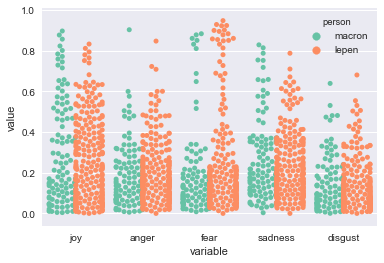

In [273]:
chart = sns.swarmplot(data=full_parsed_melted, x="variable",\
              y="value", hue="person", palette="Set2",split=True)

Hard to tell anything from this swarm plot, which I wanted to use to account for the difference in sizes of the two series, so we try a more traditional box-and-whiskers plot instead. 

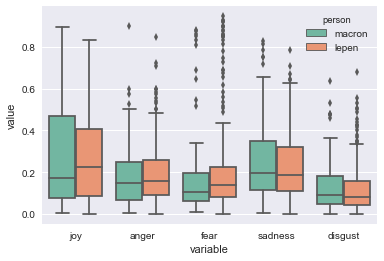

In [285]:
chart = sns.boxplot(data=full_parsed_melted, x="variable",\
              y="value", hue="person", palette="Set2")
#chart = sns.swarmplot(data=full_parsed_melted, x="variable",\
#              y="value", hue="person", palette="Set2",split=True)

Interesting -- From the box-plots it looks like the mean of the emotions are the same across the board, with perhaps the exception of joy. Lots of outliers on fear and disgust. 

I run the **Kolmogorov-Smirnov test** to compare the distributions of the emotion values between Le Pen and Macron. I choose this test because 
* you don't need your data to be normally distributed, 
* you don't have to have the same total number of points in either distributions and 
* the means (average) look pretty close to begin with, and I am interested in the entire distribution on [0,1].

In [79]:
from scipy import stats

def cdf(series):

    ser = pd.Series(series)
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    return ser_cdf.plot(drawstyle='steps')
    
#code adapted from https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python

Above, I set up a CDF plot function, cdf(), so we can compare the distributions visually to accompany the results of the KS test. 

In the graphs that follow, the distribution for text representing **Le Pen** is in **green**, while that for ***Macron*** is in* **blue***.

Ks_2sampResult(statistic=0.090902358647757975, pvalue=0.53072149215508768)

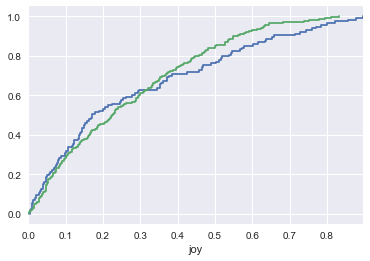

In [74]:
cdf(macron_parsed.joy)
cdf(lepen_parsed.joy)
stats.ks_2samp(lepen_parsed.joy,macron_parsed.joy)

Ks_2sampResult(statistic=0.11178583330247716, pvalue=0.27651099408513186)

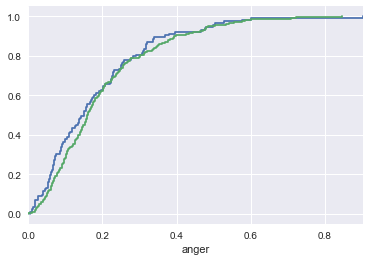

In [75]:
cdf(macron_parsed.anger)
cdf(lepen_parsed.anger)
stats.ks_2samp(lepen_parsed.anger,macron_parsed.anger)

Ks_2sampResult(statistic=0.15714444403302846, pvalue=0.040286278784689836)

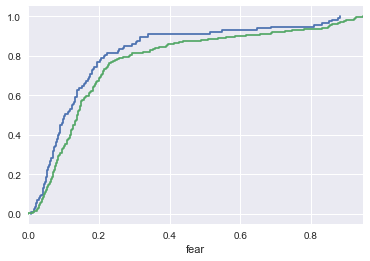

In [76]:
cdf(macron_parsed.fear)
cdf(lepen_parsed.fear)
stats.ks_2samp(lepen_parsed.fear,macron_parsed.fear)

**The above result for the Kolmogorov-Smirnov test is significant at $\alpha$ = 5%.**

Ks_2sampResult(statistic=0.076387603213981525, pvalue=0.74548509529949614)

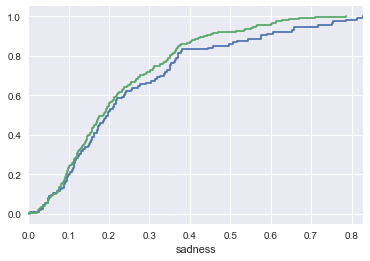

In [77]:
cdf(macron_parsed.sadness)
cdf(lepen_parsed.sadness)
stats.ks_2samp(lepen_parsed.sadness,macron_parsed.sadness)

Ks_2sampResult(statistic=0.075091642907394451, pvalue=0.76410862573107663)

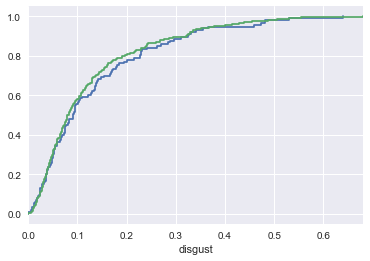

In [78]:
cdf(macron_parsed.disgust)
cdf(lepen_parsed.disgust)
stats.ks_2samp(lepen_parsed.disgust,macron_parsed.disgust)

Out of the five Kolmogorov-Smirnov tests above, it looks like the distribution of fear for Le Pen and Macron are drawn from different distributions. From the CDF's, we can see that **fear is an emotion that gets invoked more when Le Pen is mentioned**.  With a p-value of 4%, this is statistically significant where $\alpha$ = 5%! 